# 注意力自注意力多头注意力

代码参考
1. [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)
2. [vit-pytorch](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py)

## Scaled Dot-Product Attention

$$
\mathrm{Attention}(Q,K,V)=\mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

参考 1. [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

理解：
* 单单`attention`函数中不含有可学习的参数
* 注意`attention`函数支持高维的tensor <- [`torch.matmul`](https://pytorch.org/docs/stable/generated/torch.matmul.html?highlight=matmul#torch.matmul)支持batched matrix multiply
* 若`dropout=nn.Dropout(p)`，则有p的概率将p_attn中的元素置为0
* 用一个例子说明`mask`的影响

=============== w/o mask ===============
p_attn:
 tensor([[0.7704, 0.0765, 0.0765, 0.0765],
        [0.0320, 0.3227, 0.3227, 0.3227],
        [0.0320, 0.3227, 0.3227, 0.3227],
        [0.0320, 0.3227, 0.3227, 0.3227]])


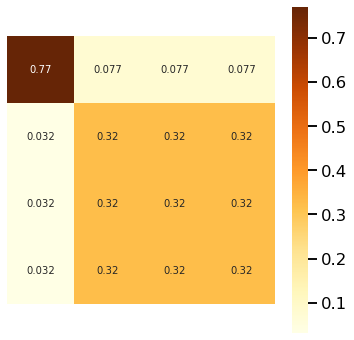

===============  wz mask ===============
p_attn:
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.0903, 0.9097, 0.0000, 0.0000],
         [0.0473, 0.4763, 0.4763, 0.0000],
         [0.0320, 0.3227, 0.3227, 0.3227]]])


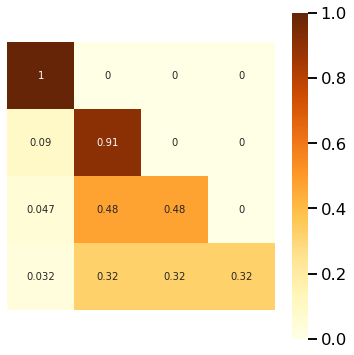

In [3]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


x = torch.Tensor(
    [
        [1, 2, 3],  # q1, k1, v1
        [3, 2, 1],  # q2, k2, v2
        [3, 2, 1],  # q3, k3, v3
        [3, 2, 1],  # q4, k4, v4
    ]
)

print("="*15, "w/o mask", "="*15)
_, p_attn = attention(x, x, x, mask=None)
print("p_attn:\n", p_attn)
plt.figure(figsize=(6,6))
seaborn.heatmap(p_attn.numpy(), annot=True, cmap="YlOrBr", square=True)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()


print("="*15, " wz mask", "="*15)
mask = subsequent_mask(x.size(0))
_, p_attn = attention(x, x, x, mask)
print("p_attn:\n", p_attn)
plt.figure(figsize=(6,6))
seaborn.heatmap(p_attn[0].numpy(), annot=True, cmap="YlOrBr", square=True)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()


===============   mask   ===============
mask:
 tensor([[[ True, False, False, False],
         [ True,  True, False, False],
         [ True,  True,  True, False],
         [ True,  True,  True,  True]]])
mask.dtype: torch.bool


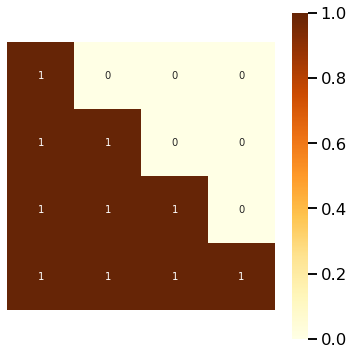

In [4]:
print("="*15, "  mask  ", "="*15)
print("mask:\n", mask)
print("mask.dtype:", mask.dtype)
plt.figure(figsize=(6,6))
seaborn.heatmap(mask[0].numpy(), annot=True, cmap="YlOrBr", square=True)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

## Multi-Head Attention

$$
\mathrm{MultiHead}(Q,K,V)=\mathrm{Concat}(\mathrm{head}_1,\cdots,\mathrm{head}_h)W^O,\quad W^O\in\mathbb{R}^{hd_v\times d_{model}}\\
\mathrm{head}_i=\mathrm{Attention}(QW_i^{Q},KW_i^{K},VW_i^{V}),\quad W_i^Q,W_i^K\in\mathbb{R}^{d_{model}\times d_{k}},W_i^V\in\mathbb{R}^{d_{model}\times d_{v}}
$$

$h=8,d_{model}=512,d_k=d_v=d_{model}/h=64$

参考 1. [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [5]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using x view and apply x final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

理解：
* `MultiHeadedAttention`代码看起来云里雾里的，运行一个例子输出shape看一下

In [6]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        print("="*20, "0", "="*20)
        print("query.shape", query.shape)
        print("key.shape", key.shape)
        print("value.shape", value.shape)
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        print("="*20, "1", "="*20)
        print("query.shape", query.shape)
        print("key.shape", key.shape)
        print("value.shape", value.shape)

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)
        print("="*20, "2", "="*20)
        print("x.shape", x.shape)
        print("self.attn.shape", (self.attn).shape)

        # 3) "Concat" using x view and apply x final linear.
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        print("="*20, "3", "="*20)
        print("x.shape", x.shape)

        return self.linears[-1](x)

x = torch.rand((2, 20, 512))
mattn = MultiHeadedAttention(h=8, d_model=512, dropout=0.1)
out = mattn(x, x, x)
print("="*19, "out", "="*19)
print("out.shape", out.shape)

==================== 0 ====================
query.shape torch.Size([2, 20, 512])
key.shape torch.Size([2, 20, 512])
value.shape torch.Size([2, 20, 512])
==================== 1 ====================
query.shape torch.Size([2, 8, 20, 64])
key.shape torch.Size([2, 8, 20, 64])
value.shape torch.Size([2, 8, 20, 64])
==================== 2 ====================
x.shape torch.Size([2, 8, 20, 64])
self.attn.shape torch.Size([2, 8, 20, 20])
==================== 3 ====================
x.shape torch.Size([2, 20, 512])
=================== out ===================
out.shape torch.Size([2, 20, 512])


理解：

0.  
    
        a) 参数query，key，value初始的shape是 (B, N, d_model)

        b) 函数返回的tensor的shape也是 (B, N, d_model)

        c) 所以可以有残差连接

1. 
    ```python
    [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                 for l, x in zip(self.linears, (query, key, value))]
    ```
       分别对初始的query，key，value进行了三步操作

       a) (B, N, d_model) -Linear-> (B, N, d_model)

       b) (B, N, d_model) -view-> (B, N, h, d_k) 其中d_model = h * d_k

       c) (B, N, h, d_k) -transpose-> (B, h, N, d_k)

2. 
    ```python
    x, self.attn = attention(query, key, value, mask=mask,
                                 dropout=self.dropout)
    ```
        计算了高维的query，key，value的注意力(batched)
        
        a) query (B, h, N, d_k)  key^T (B, h, d_k, N) -> p_attn (B, h, N, N)
        
        b) p_attn (B, h, N, N) value (B, h, N, d_k) -> x (B, h, N, d_k)
 
3. 
    ```python
    x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
    ```
        利用维度变化实现了concat
        
        a) x (B, h, N, d_k) -transpose-> x (B, N, h, d_k)
        
        b) x (B, N, h, d_k) -view-> x (B, N, d_model)
 
4. 
    ```python
    self.linears[-1](x) 
    ```
        实现了最后与$W^O$的矩阵乘法
    

参考 2. [vit-pytorch](https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py)

论文[Appendix A MULTIHEAD SELF-ATTENTION](https://arxiv.org/pdf/2010.11929v2.pdf) 中多头自注意力机制公式

![avatar](vit_appendix.png)

```python
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)
```